In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, InputLayer, Dropout, Flatten, BatchNormalization, Conv1D
from tensorflow.keras.layers import concatenate
from keras.utils import to_categorical
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats

In [131]:
file = open('F:/HAR/WISDM/WISDM_ar_v1.1_raw.txt')
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [132]:
columns = ['user', 'activity', 'time', 'x', 'y', 'z']

In [133]:
df = pd.DataFrame(data = processedList, columns = columns)
df.head()

,user,activity,time,x,y,z
0,33,Jogging,49105962326000,-0.6946377,12.680544,0.50395286
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209
3,33,Jogging,49106222305000,-0.61291564,18.496431,3.0237172
4,33,Jogging,49106332290000,-1.1849703,12.108489,7.205164


In [135]:
df.isnull().sum()

user        0
activity    0
time        0
x           0
y           0
z           0
dtype: int64

In [171]:
df['activity'].value_counts()

activity
Sitting     4599
Standing    3555
Name: count, dtype: int64

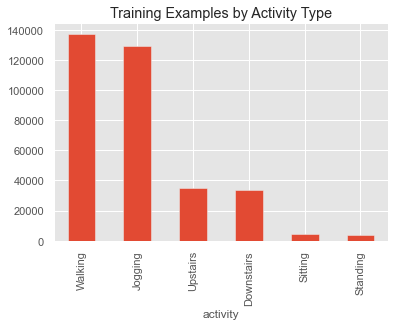

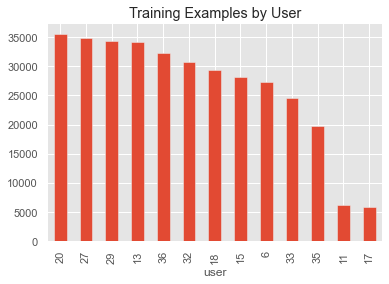

In [108]:

# Show how many training examples exist for each of the six activities
df["activity"].value_counts().plot(kind = "bar", title = "Training Examples by Activity Type")
plt.show()
# Better understand how the recordings are spread across the different users who participated in the study
df["user"].value_counts().plot(kind = "bar", title = "Training Examples by User")
plt.show()

In [172]:
df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['z'] = df['z'].astype('float')

In [173]:
activities = df['activity'].value_counts().index

In [174]:
label = LabelEncoder()
df['activity'] = label.fit_transform(df['activity'])
df.head()

,user,activity,time,x,y,z,ActivityEncoded
221333,27,0,12363992261000,2.6,9.7,1.0,0
221334,27,0,12364042279000,2.7,9.5,0.5,0
221335,27,0,12364092267000,3.5,8.9,0.8,0
221336,27,0,12364142316000,3.6,9.4,0.9,0
221337,27,0,12364192273000,2.9,9.3,1.0,0


In [167]:
activities

Index(['Sitting', 'Standing'], dtype='object', name='activity')

In [168]:

# "Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"

indexes = df[ (df['activity'] == 'Jogging') | (df['activity'] == 'Downstairs')| (df['activity'] == 'Upstairs')| (df['activity'] == 'Walking')].index
df.drop(indexes , inplace=True)


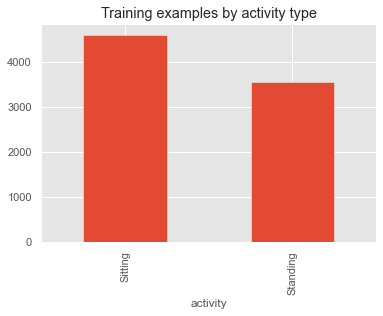

In [169]:
df['activity'].value_counts().plot(kind='bar', title='Training examples by activity type');

In [170]:
num_classes = 2 # static activity 갯수

In [175]:
from sklearn import preprocessing

# Define column name of the label vector
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df["activity"].values.ravel())

In [176]:
X = df[['x', 'y', 'z']]
y = df['ActivityEncoded']

In [177]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

scaled_X = pd.DataFrame(data = X, columns = ['x', 'y', 'z'])
scaled_X['label'] = y.values

scaled_X

,x,y,z,label
0,1.1,0.7,-0.6,0
1,1.1,0.7,-0.7,0
2,1.4,0.5,-0.7,0
3,1.4,0.6,-0.6,0
4,1.2,0.6,-0.6,0
...,...,...,...,...
8149,-0.1,0.6,-0.2,1
8150,-0.2,0.7,-0.2,1
8151,-0.3,0.7,-0.2,1
8152,-0.5,0.5,-0.3,1


In [178]:
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40

In [179]:
def get_frames(df, frame_size, hop_size):

    N_FEATURES = 3

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        x = df['x'].values[i: i + frame_size]
        y = df['y'].values[i: i + frame_size]
        z = df['z'].values[i: i + frame_size]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

In [180]:
X, y = get_frames(scaled_X, frame_size, hop_size)

<ipython-input-179-351285eacf6e>:13: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df['label'][i: i + frame_size])[0][0]


In [181]:
X.shape, y.shape

((202, 80, 3), (202,))

In [182]:
X_train[0].shape, X_test[0].shape

((80, 3, 1), (80, 3, 1))

In [183]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [184]:
X_train.shape, X_test.shape

#reshape때 사용

((161, 80, 3), (41, 80, 3))

In [185]:
X_train[0].shape, X_test[0].shape

((80, 3), (80, 3))

In [186]:
X_train = X_train.reshape(161, 80, 3, 1)
X_test = X_test.reshape(41, 80, 3, 1)

In [187]:
X_train[0].shape, X_test[0].shape

((80, 3, 1), (80, 3, 1))

In [188]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

In [189]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))
# 2개 class만 분류하므로 2로 수정

In [190]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [191]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 79, 2, 16)         80        
                                                                 
 dropout_27 (Dropout)        (None, 79, 2, 16)         0         
                                                                 
 conv2d_19 (Conv2D)          (None, 78, 1, 32)         2080      
                                                                 
 dropout_28 (Dropout)        (None, 78, 1, 32)         0         
                                                                 
 flatten_9 (Flatten)         (None, 2496)              0         
                                                                 
 dense_18 (Dense)            (None, 64)                159808    
                                                                 
 dropout_29 (Dropout)        (None, 64)              

In [192]:
history = model.fit(X_train, y_train, epochs = 10, validation_data= (X_test, y_test), verbose=1)

Epoch 1/10
6/6 [==============================] - 1s 43ms/step - loss: 1.0868 - accuracy: 0.5652 - val_loss: 0.3979 - val_accuracy: 0.9512
Epoch 2/10
6/6 [==============================] - 0s 13ms/step - loss: 0.3744 - accuracy: 0.8634 - val_loss: 0.1378 - val_accuracy: 0.9756
Epoch 3/10
6/6 [==============================] - 0s 13ms/step - loss: 0.1370 - accuracy: 0.9689 - val_loss: 0.0782 - val_accuracy: 0.9756
Epoch 4/10
6/6 [==============================] - 0s 11ms/step - loss: 0.0524 - accuracy: 1.0000 - val_loss: 0.0557 - val_accuracy: 0.9756
Epoch 5/10
6/6 [==============================] - 0s 13ms/step - loss: 0.0255 - accuracy: 1.0000 - val_loss: 0.0423 - val_accuracy: 0.9756
Epoch 6/10
6/6 [==============================] - 0s 12ms/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.0363 - val_accuracy: 0.9756
Epoch 7/10
6/6 [==============================] - 0s 12ms/step - loss: 0.0085 - accuracy: 1.0000 - val_loss: 0.0356 - val_accuracy: 0.9756
Epoch 8/10
6/6 [===========

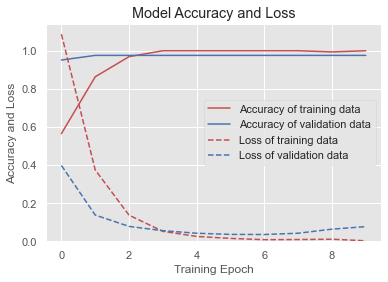

NameError: name 'x_train' is not defined

In [194]:
from sklearn.metrics import classification_report

plt.figure(figsize=(6, 4))
plt.plot(history.history["accuracy"], 'r', label = "Accuracy of training data")
plt.plot(history.history["val_accuracy"], 'b', label = "Accuracy of validation data")
plt.plot(history.history["loss"], 'r--', label = "Loss of training data")
plt.plot(history.history["val_loss"], 'b--', label = "Loss of validation data")
plt.title("Model Accuracy and Loss")
plt.ylabel("Accuracy and Loss")
plt.xlabel("Training Epoch")
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis = 1)
print(classification_report(y_train, max_y_pred_train))


In [ ]:
model = Sequential()
model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = X_train[0].shape))
model.add(Dropout(0.1))

model.add(Conv2D(32, (2, 2), activation='relu'))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))

model.add(Dense(6, activation='softmax'))